In [33]:
# Import libraries and standardize path
import os
from pathlib import Path
import numpy as np
import cv2
from tkinter.filedialog import askopenfilename
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import zoom
from skimage import exposure
from skimage.transform import resize
from PIL import Image


In [34]:
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")
# Change directory as needed
os.chdir("/Users/Jacks/Desktop/Jackson's Homework/Year 4/BMEG 457/MRI-TO-PCT/Capstone Code and resources")

Current working directory: d:\Users\Jacks\Desktop\Jackson's Homework\Year 4\BMEG 457\MRI-TO-PCT\Capstone Code and resources


MRI Volume Shape: (256, 256, 256)
Coronal Slice Shape: (256, 256)


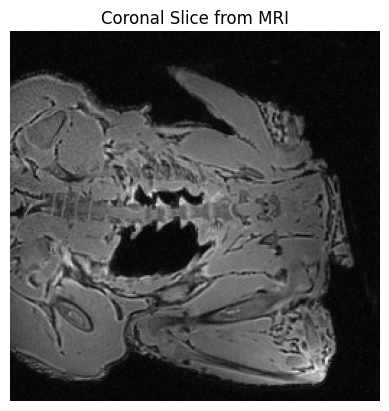

In [35]:
# Load Full MRI Volume
mri_nifti = nib.load("Data/ute_0_3mm_corrected.nii.gz")
mri_data = mri_nifti.get_fdata()

print("MRI Volume Shape:", mri_data.shape)  # Expected shape (X, Y, Z)

# Extract Coronal Slice
middle_coronal_index = 83 # TODO: CHANGE THIS OUT FOR OTHER SLICES
mri_coronal_slice = mri_data[:, middle_coronal_index, :]  

print("Coronal Slice Shape:", mri_coronal_slice.shape)  # Expected shape (n, d)

# Normalize MRI Image
mri_min, mri_max = np.min(mri_coronal_slice), np.max(mri_coronal_slice)
coronal_norm = ((mri_coronal_slice - mri_min) / (mri_max - mri_min) * 255).astype(np.uint8)

# Save as PNG
image = Image.fromarray(coronal_norm)
image.save("Images/starting_chicken_coronal_slice.png")

plt.imshow(coronal_norm, cmap="gray")
plt.title("Coronal Slice from MRI")
plt.axis("off")
plt.show()

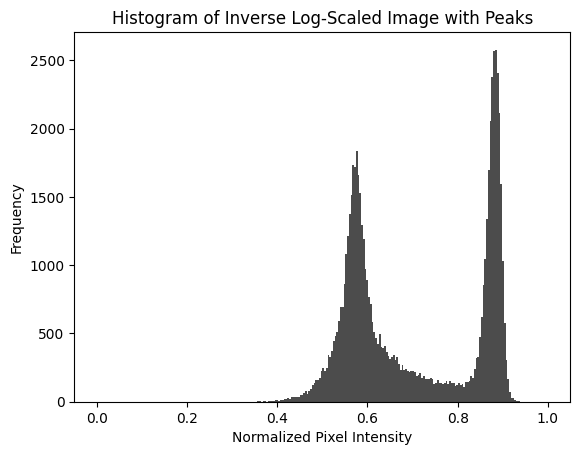

Thresholds for Peaks: []


In [60]:
# Section for inverse log scaling + bias correction

# image = cv2.imread(mri_coronal_slice, cv2.IMREAD_GRAYSCALE)
# if image is None:
#     raise FileNotFoundError(f"Image could not be loaded. Check the file path.")

# Convert to SimpleITK image format and cast to float
image_sitk = sitk.GetImageFromArray(mri_coronal_slice)
image_sitk = sitk.Cast(image_sitk, sitk.sitkFloat32)

# Bias Field Correction (N4ITK)
corrector = sitk.N4BiasFieldCorrectionImageFilter()

# play around with hyperparameters--------------------------------------------------------
# Degree of the B-spline used for bias correction (smoothness)
corrector.SetSplineOrder(2)  # 2 looks the best
# Determines when the correction stops
corrector.SetConvergenceThreshold(10 ** -3)  # 10^-3 or smaller is best
# Impacts the histogram size for intensity mapping
corrector.SetNumberOfHistogramBins(50) # best is i = 50
# Controls the number of iterations at each resolution level
corrector.SetMaximumNumberOfIterations([50, 50, 50, 50])  # best is standard -> i = 50
#-----------------------------------------------------------------------------------------

# Execute bias correction
corrected_image_sitk = corrector.Execute(image_sitk)

# Convert corrected image to NumPy array
corrected_image = sitk.GetArrayFromImage(corrected_image_sitk)

# Normalize corrected image back to [0, 1] range
corrected_image = corrected_image / np.max(corrected_image)

# Scale to [0, 255] for saving as an image
corrected_image_uint8 = np.uint8(255 * corrected_image)

# Save corrected image

log_image = np.log(corrected_image + 1)  # Avoid log(0)
log_image = np.uint8(255 * log_image)
inverse_log_image = 255 - log_image  


inv_norm = inverse_log_image / 255.0

hist, bins = np.histogram(inv_norm.ravel(), bins=256, range=(0, 1))

#Change height to identify peaks 
peaks, _ = find_peaks(hist, height=7100)

# Threshold values
thresholds = bins[peaks]

plt.hist(inv_norm.ravel(), bins=256, range=(0, 1), color='black', alpha=0.7)
plt.scatter(thresholds, hist[peaks], color='red', zorder=5)
plt.title('Histogram of Inverse Log-Scaled Image with Peaks')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

print('Thresholds for Peaks:', thresholds)

# ----------------

# image_sitk = sitk.GetImageFromArray(image)
# image_sitk = sitk.Cast(image_sitk, sitk.sitkFloat32) # Need to cast to float to avoid uint8 errors

# # Bias Field Correction (N4ITK)
# corrector = sitk.N4BiasFieldCorrectionImageFilter()
# corrected_image_sitk = corrector.Execute(image_sitk)

# corrected_image = sitk.GetArrayFromImage(corrected_image_sitk)
# corrected_image = corrected_image / np.max(corrected_image) # Normalization from [0 - 1]

# log_image = np.log(corrected_image + 1) # Avoids log(0)
# log_image = np.uint8(255 * log_image)

# inverse_log_image = 255 - log_image  
# cv2.imwrite('/Users/yuhengzhang/Documents/BMEG 457/MRI-TO-PCT/Capstone Code and resources/Images/Yuheng_inverse_log_scaled_image.png', inverse_log_image)

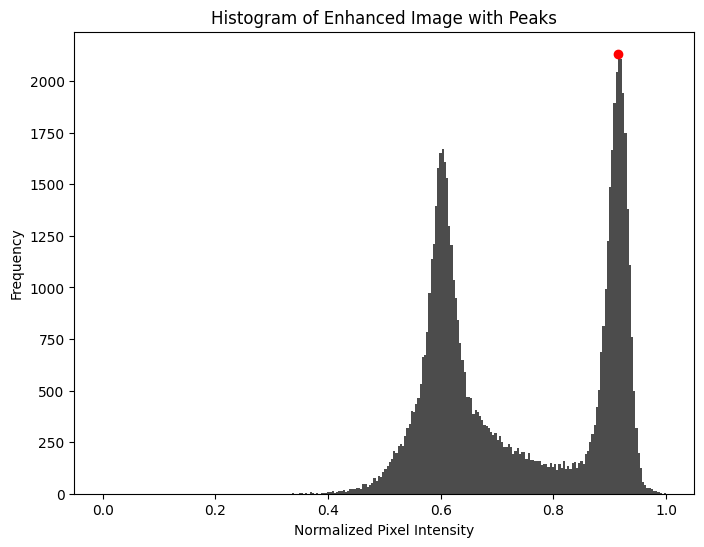

Thresholds for Peaks: [0.9140625]


In [37]:
# Histogram Based bias correction applied to N4ITK approach

# Convert image to SimpleITK and float format
image_sitk = sitk.GetImageFromArray(mri_coronal_slice)
image_sitk = sitk.Cast(image_sitk, sitk.sitkFloat32)

corrector = sitk.N4BiasFieldCorrectionImageFilter()
corrector.SetSplineOrder(2)
corrector.SetConvergenceThreshold(1e-4)
corrector.SetNumberOfHistogramBins(100)
corrector.SetMaximumNumberOfIterations([100, 100, 100, 100])

corrected_image_sitk = corrector.Execute(image_sitk)
corrected_image = sitk.GetArrayFromImage(corrected_image_sitk)

# Normalize corrected image to [0,1]
corrected_image = corrected_image / (np.max(corrected_image) + 1e-8)

log_image = np.log1p(corrected_image)  
inverse_log_image = 1.0 - log_image  
inverse_log_image /= np.max(inverse_log_image)  

def histogram_bias_correction(image, num_bins=256, min_counts=50, smoothing_sigma=5, levels=[1, 2, 4, 8]):
    corrected = np.copy(image).astype(np.float32)
    bias_field = np.ones_like(image, dtype=np.float32)

    for level in levels:
        downsampled_image = cv2.resize(corrected, (corrected.shape[1] // level, corrected.shape[0] // level), interpolation=cv2.INTER_LINEAR)

        hist, bin_edges = np.histogram(downsampled_image, bins=num_bins)
        max_count_idx = np.argmax(hist)  # Peak index
        if hist[max_count_idx] > min_counts:
            peak_intensity = bin_edges[max_count_idx]

            bias_field[:downsampled_image.shape[0], :downsampled_image.shape[1]] = peak_intensity

        # Apply Low-Pass Filtering 
        bias_field = gaussian_filter(bias_field, sigma=smoothing_sigma)

        
        corrected = corrected / (bias_field + 1e-8)  # Normalize
        corrected /= np.max(corrected)  # Scale to [0,1]

    return corrected

# Apply Histogram-Based Bias Correction 
final_corrected_image = histogram_bias_correction(inverse_log_image)

inv_norm = final_corrected_image  

# Compute histogram
hist, bins = np.histogram(inv_norm.ravel(), bins=256, range=(0, 1))

peak_threshold = max(1000, np.percentile(hist, 98))
peaks, _ = find_peaks(hist, height=peak_threshold)

thresholds = bins[peaks]

plt.figure(figsize=(8, 6))
plt.hist(inv_norm.ravel(), bins=256, range=(0, 1), color='black', alpha=0.7)
plt.scatter(thresholds, hist[peaks], color='red', zorder=5)
plt.title('Histogram of Enhanced Image with Peaks')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

print('Thresholds for Peaks:', thresholds)


C:\Users\Jacks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_gaussian_mixture.py:826: RuntimeWarning: divide by zero encountered in log
  return np.log(self.weights_)


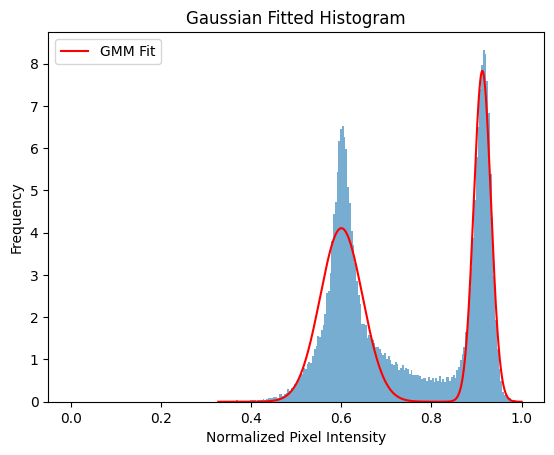

In [38]:
# Gaussian Fitting of Histogram
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3 ,random_state=42) # ADDING THREE COMPONENTS SEEMS TO WORK BETTER
gmm.fit(inv_norm.ravel().reshape(-1, 1))

# Extract model parameters
means = gmm.means_.flatten()
std_devs = np.sqrt(gmm.covariances_).flatten()

# Sort means smallest to largest 
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_std_devs = std_devs[sorted_indices]

# Set the weight of the second peak to zero
gmm.weights_[sorted_indices[1]] = 0
#gmm.weights_[sorted_indices[2]] = 0
weights = gmm.weights_

# Plot histogram and fitted GMM
x = np.linspace(inv_norm.ravel().min(), inv_norm.ravel().max(), 1000)
pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

plt.hist(inv_norm.ravel(), bins=256, density = True, range=(0, 1), alpha=0.6)
plt.plot(x, pdf, color='red', label="GMM Fit")
plt.title('Gaussian Fitted Histogram')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

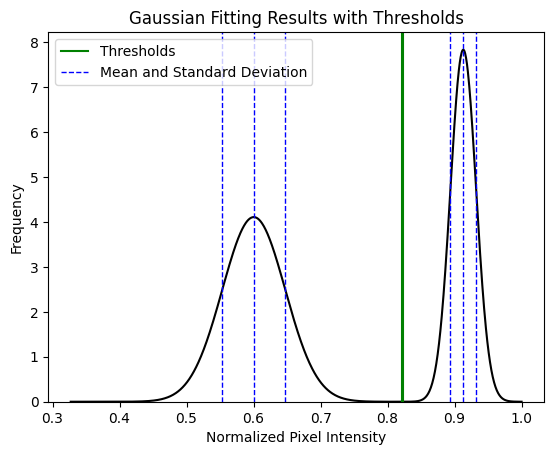

In [39]:
# Automatic Thresholding 
# Determine the signal and noise center
signal_center = sorted_means[0]
noise_center = sorted_means[2]

# FWHM = 2 * sqrt(2ln(2)) * σ where sigma is the standard deviation
signal_fwhm = 2*np.sqrt(2*np.log(2))*sorted_std_devs[0]
noise_fwhm = 2*np.sqrt(2*np.log(2))*sorted_std_devs[2]

# Select Thresholds [center(signal) + 2*FWHM(signal), center(noise)−2*FWHM(noise)]
lower_threshold = signal_center + 2*signal_fwhm
upper_threshold = noise_center - 2*noise_fwhm

# Plot histogram with thresholds 
plt.plot(x, pdf, color='black')
plt.title('Gaussian Fitting Results with Thresholds')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.ylim(bottom = 0)

# Add vertical lines
plt.axvline(x=lower_threshold, color='green', linestyle='-', label = 'Thresholds')
plt.axvline(x=upper_threshold, color='green', linestyle='-')
plt.axvline(x=signal_center, color='blue', linestyle='--', linewidth=1, label = 'Mean and Standard Deviation')
plt.axvline(x=noise_center, color='blue', linestyle='--', linewidth=1)
plt.axvline(x=signal_center + sorted_std_devs[0], color='blue', linestyle='--', linewidth=1)
plt.axvline(x=signal_center - sorted_std_devs[0], color='blue', linestyle='--', linewidth=1)
plt.axvline(x=noise_center + sorted_std_devs[2], color='blue', linestyle='--', linewidth=1)
plt.axvline(x=noise_center - sorted_std_devs[2], color='blue', linestyle='--', linewidth=1)
plt.legend()

plt.show()

In [ ]:
# Select Thresholds [center(signal) + 2*FWHM(signal), center(noise)−2*FWHM(noise)]
lower_threshold = signal_center + 2*signal_fwhm
upper_threshold = noise_center - 2*noise_fwhm

lower_threshold = 0.58
upper_threshold = 0.86

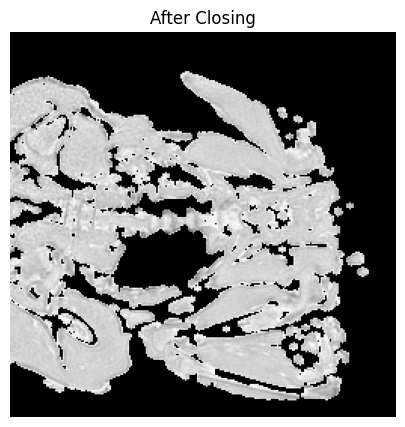

True

In [50]:
# Section for Segmentation based on Previous Thresholds
segmented_image = inverse_log_image

# Segment the image based on thresholds (masking from literature)
# NOTE: Masks may need to be switched around based on the DICOM pictures (i.e if bone is darker and background is lighter)
soft_tissue_mask = (inv_norm < lower_threshold) 
bone_mask = (inv_norm >= lower_threshold) & (inv_norm < upper_threshold)  
air_mask = (inv_norm >= upper_threshold) 

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))  # Adjust kernel size if needed


# Convert to binary image using bone_mask.astype(np.uint8) 
# closed_soft_tissue_mask = cv2.morphologyEx(soft_tissue_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
# closed_bone_mask = cv2.morphologyEx(bone_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
closed_air_mask = cv2.morphologyEx(air_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)


# Assign greyscale values for segment display
segmented_image[closed_air_mask == 1] = 0          # Air = Black
# segmented_image[closed_soft_tissue_mask] = 128  # Soft Tissue = Mid Grey (128)
# segmented_image[closed_bone_mask == 1] = 255       # Bone = White

# Display results
plt.figure(figsize=(10, 5))
plt.imshow(segmented_image, cmap="gray")
plt.title("After Closing")
plt.axis("off")

plt.show()

# Save results
cv2.imwrite('Images/Closed_CFP_segmented_image_automatic_presentation.png', segmented_image)

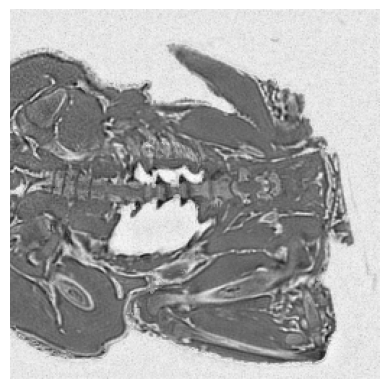

In [63]:
# Original without Morphological Closing
# Section for Segmentation based on Previous Thresholds
segmented_image = inverse_log_image

# Manually choose thresholds based on above histogram bins and inverse log scaled image
threshold1 = 0.58 # or threshold[0] + 0.02, threshold[1], etc.
threshold2 = 0.86

# Segment the image based on thresholds (masking from literature)
# NOTE: Masks may need to be switched around based on the DICOM pictures (i.e if bone is darker and background is lighter)
soft_tissue_mask = (inv_norm < threshold1) 
bone_mask = (inv_norm >= threshold1) & (inv_norm < threshold2)  
air_mask = (inv_norm >= threshold2) 

# Assign greyscale values for segment display
# segmented_image[air_mask] = 0  
# segmented_image[soft_tissue_mask] = 100
# segmented_image[bone_mask] = 255

# Save and display
save_segmented_image = Image.fromarray(segmented_image)
save_segmented_image.save('Images/CFP_segmented_image.png')
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.show()


MRI Volume Shape: (256, 256, 256)
Coronal Slice Shape: (256, 256)


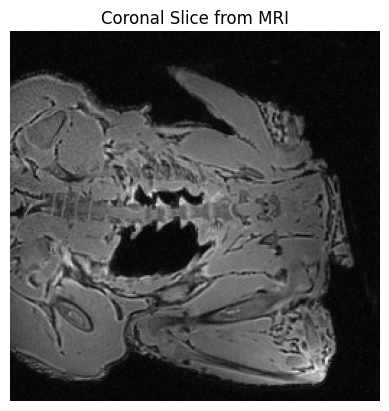

In [43]:
### VERIFICATION AND VALIDATION

# Load Full MRI Volume
mri_nifti = nib.load("Data/ute_0_3mm_corrected.nii.gz")
mri_data = mri_nifti.get_fdata()

print("MRI Volume Shape:", mri_data.shape)  # Expected shape (X, Y, Z)

# Extract Coronal Slice
middle_coronal_index = 83 # TODO: CHANGE THIS OUT FOR OTHER SLICES
mri_coronal_slice = mri_data[:, middle_coronal_index, :]  

print("Coronal Slice Shape:", mri_coronal_slice.shape)  # Expected shape (n, d)

# Normalize MRI Image
mri_min, mri_max = np.min(mri_coronal_slice), np.max(mri_coronal_slice)
coronal_norm = ((mri_coronal_slice - mri_min) / (mri_max - mri_min) * 255).astype(np.uint8)

# Save as PNG
image = Image.fromarray(coronal_norm)
image.save("Images/validation_coronal_slice.png")

plt.imshow(coronal_norm, cmap="gray")
plt.title("Coronal Slice from MRI")
plt.axis("off")
plt.show()

CT Volume Shape: (512, 512, 1995)
Best matching CT coronal slice: 340 (SSIM: 0.1283)


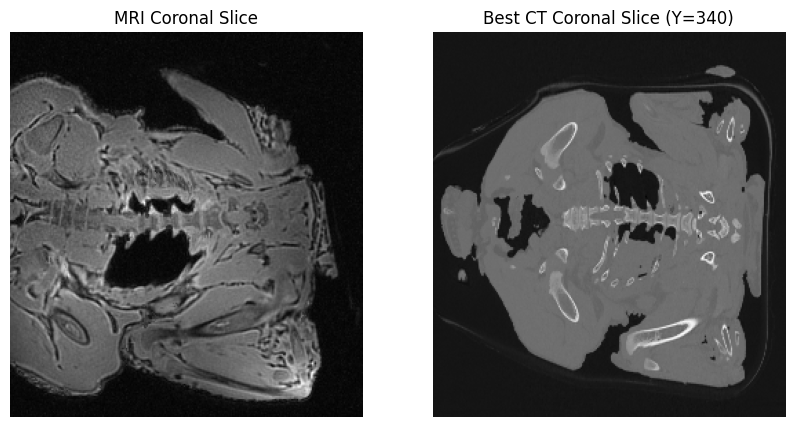

In [71]:
from skimage.transform import resize

# Load Full CT Volume
ct_nifti = nib.load("Data/2 Chicken 020 Br89 Q3 R.nii.gz")
ct_data = ct_nifti.get_fdata()
print("CT Volume Shape:", ct_data.shape) # Expected shape (X, Y, Z)

# Find Best-Matching CT Slice Using SSIM
best_ssim = -np.inf
best_y_index = -1

for y in range(ct_data.shape[1]):  # Loop through all coronal slices in CT, 0 is axial? 1 is coronal
    ct_coronal_slice = ct_data[:, y, :]  # Extract coronal slice (512, 512)

    # Need to downsample to match MRI shape
    ct_resized = resize(ct_coronal_slice, (256, 256), anti_aliasing=False)

    # Compute SSIM
    ssim_score = ssim(mri_coronal_slice, ct_resized, data_range=ct_resized.max() - ct_resized.min())

    # Track best match
    if ssim_score > best_ssim:
        best_ssim = ssim_score
        best_y_index = y
        best_ct_slice = ct_resized 

print(f"Best matching CT coronal slice: {best_y_index} (SSIM: {best_ssim:.4f})")

# Plot MRI and Best CT Slice 
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mri_coronal_slice, cmap="gray", aspect="auto")
plt.title("MRI Coronal Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(best_ct_slice, cmap="gray", aspect="auto")
plt.title(f"Best CT Coronal Slice (Y={best_y_index})")
plt.axis("off")

plt.show()

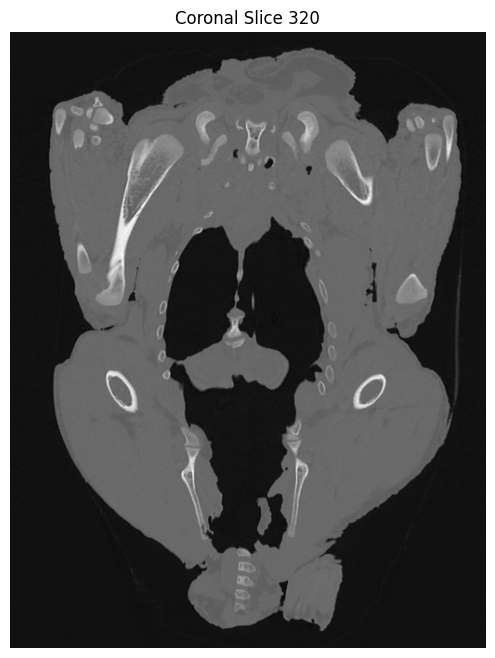

In [74]:
# Manually find CT Slice by Changing Index, need to run above section first

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Get voxel spacing (mm per pixel in each dimension)
voxel_spacing = ct_nifti.header.get_zooms()
spacing_x, spacing_y, spacing_z = voxel_spacing  # Typically (X, Y, Z)

# Get the number of coronal slices
num_slices = ct_data.shape[1]  # Coronal axis

# Slice
temp_val = 320 # Change value here
coronal_slice = ct_data[:, temp_val, :]  

# Adjust aspect ratio
plt.figure(figsize=(8, 8))  # Adjust figure size
plt.imshow(coronal_slice.T, cmap="gray", origin="lower", 
            aspect=spacing_z / spacing_x)  # Correct aspect ratio
plt.title(f"Coronal Slice {temp_val}")
plt.axis("off")
plt.show()

